In [ ]:
# colab 사용 시! Local PC로 실습하는 경우 실행 x / 단, 작업경로를 2025_LGE_DNN으로 맞춰주기

!git clone https://github.com/Im-JihyunKim/2025_LGE_DNN.git
%cd /content/2025_LGE_DNN

In [ ]:
from IPython.display import Image

# TO DO: PyTorch로 모델 학습하기
- 모델 학습 목적: 고양이(Cat)와 강아지(Dog)를 잘 분류하는 것

In [ ]:
import os
from glob import glob  # glob 모듈에서 glob라는 클래스를 직접적으로 불러오기
import torch
import random
from PIL import Image as Img
import numpy as np
from sklearn.model_selection import train_test_split

import torchvision.transforms as tf
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
from torchsummary import summary

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# 똑같은 결과를 얻기 위한 시드 고정
seed = 0
torch.manual_seed(seed) # torch cpu seed 고정
torch.cuda.manual_seed(seed) # torch gpu seed 고정
torch.cuda.manual_seed_all(seed) # torch multi-gpu seed 고정
np.random.seed(seed) # numpy seed 고정
random.seed(seed) # python seed 고정

## 1. Dataset and DataLoader 구축
- 고양이와 강아지 데이터셋을 불러오고 모델에 입력할 수 있는 형태로 만들기
- Mini Batch 형태로 쪼개어 loader로 불러오기

In [ ]:
# CatDogDataset
class CatDogDataset(Dataset):
    def __init__(self, img_path, labels, mode):

      # 데이터셋 로드를 위한 인스턴스 변수 / attributes
      self.img_path = img_path  # 데이터셋이 포함된 항목의 파일 경로를 저장 -> getitem에서 데이터 로드시 사용됨
      self.labels = labels  # 데이터셋의 각 x 샘플과 매핑되는 레이블 내지는 타겟 값을 저장

      if mode == 'train':
        # 학습 시에 적용될 데이터 전처리 정의
        self.transform = tf.Compose([
                                    # tf.ToPILImage(), 만약 데이터가 array나 tensor로 되어 있는 경우 PILImage로 변경이 필요
                                    tf.RandomResizedCrop(size=(128,128)),
                                    tf.RandomHorizontalFlip(p=0.5),
                                    tf.ToTensor(),
                                    tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                                  ])
      else: # valid or test 시에 적용될 데이터 전처리
        self.transform = tf.Compose([
                                    tf.Resize(size=(128,128)),
                                    tf.ToTensor(),
                                    tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

    def __len__(self):
      return len(self.img_path)
    
    def __getitem__(self,idx):
      img = Img.open(self.img_path[idx]) # 이미지 오픈
      X = self.transform(img) # 이미지 변형
      
      y = self.labels[idx]
      
      return {'X':X, 
              'y': y}

- CatDogDataset을 활용하여 데이터를 불러오기 위해서는 아래 인자들을 사전정의하여서 input으로 넣어주어야 함
    1. img_path: 데이터셋이 포함된 파일 경로
    2. labels: 데이터셋의 각 x 샘플과 mapping되는 정답 데이터
    3. mode: train/valid/test

### 1-1. mode 별로 img_path & labels 정의

In [ ]:
## 1. Trainset, validset구축 위한 데이터 로드
cat_train_path = glob(f'./data/dog_cat/train/cat/*') # train 폴더 cat 이미지 경로
cat_train_labels = [0]*len(cat_train_path) # cat에 대한 레이블 생성

dog_train_path = glob(f'./data/dog_cat/train/dog/*') # train 폴더 dog 이미지 경로
dog_train_labels = [1]*len(dog_train_path) # dog에 대한 레이블 생성


## 2. train 데이터와 valid 데이터 분할하기
    # cf. 본 데이터셋은 train, test가 명확히 폴더 별로 구분되어 있는 케이스이며, 현업 데이터셋에서는 학습-테스트셋을 직접 지정
# 2-1. Cat data: train/valid 분할을 위해서 이미지 경로 섞기
random.shuffle(cat_train_path)
cut_index = int(len(cat_train_path) * 0.7)  # cat train 이미지 중 70%만을 실제 학습에 이용
cat_train_path, cat_valid_path = cat_train_path[:cut_index], cat_train_path[cut_index:]  # x 데이터 train, valid 분할
cat_train_labels, cat_valid_labels = cat_train_labels[:cut_index], cat_train_labels[cut_index:] # y 데이터 train, valid 분할

# 2-2. Dog data: train/valid 분할을 위해서 이미지 경로 섞기
random.shuffle(dog_train_path)
cut_index = int(len(dog_train_path) * 0.7)
dog_train_path, dog_valid_path = dog_train_path[:cut_index], dog_train_path[cut_index:]
dog_train_labels, dog_valid_labels = dog_train_labels[:cut_index], dog_train_labels[cut_index:]


## 3. trainset을 위한 cat 이미지와 dog 이미지
train_path = dog_train_path + cat_train_path
train_labels = dog_train_labels + cat_train_labels


## 4. validset을 위한 cat 이미지와 dog 이미지
valid_path = dog_valid_path + cat_valid_path
valid_labels = dog_valid_labels + cat_valid_labels


## 5. testset 구축을 위한 데이터 로드
# 5-1. test 폴더 이미지 경로로 데이터셋 불러오기
cat_test_path = glob(f'./data/dog_cat/test/cat/*')
cat_test_labels = [0]*len(cat_test_path)

dog_test_path = glob(f'./data/dog_cat/test/dog/*')
dog_test_labels = [1]*len(dog_test_path)

# 5-2. testset을 위한 cat 이미지 + dog 이미지
test_path = dog_test_path + cat_test_path
test_labels = dog_test_labels + cat_test_labels

In [ ]:
print(f'trainset 이미지 수 : {len(train_path)}')
print(f'validset 이미지 수 : {len(valid_path)}')
print(f'testset 이미지 수  : {len(test_path)}')

trainset 이미지 수 : 140
validset 이미지 수 : 62
testset 이미지 수  : 102


### 1-2. mode 별 Dataset과 Dataloader 정의

In [ ]:
# 학습/테스트 데이터셋 및 데이터로더 생성
trainset = CatDogDataset(img_path=train_path, 
                         labels=train_labels,
                         mode='train')

validset = CatDogDataset(img_path=valid_path, 
                         labels=valid_labels,
                         mode='valid')

testset = CatDogDataset(img_path=test_path, 
                         labels=test_labels,
                         mode='test')

trainloader = DataLoader(dataset=trainset, 
                         batch_size=64,
                         shuffle=True,
                         drop_last=False)

validloader = DataLoader(dataset=validset, 
                         batch_size=64,
                         shuffle=False,
                         drop_last=False)

testloader = DataLoader(dataset=testset, 
                         batch_size=64,
                         shuffle=False,
                         drop_last=False)

In [ ]:
batch = next(iter(trainloader))  # train batch
print(batch.keys())
print(batch['y'])

dict_keys(['X', 'y'])
tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0])


## 2. 모델 구축

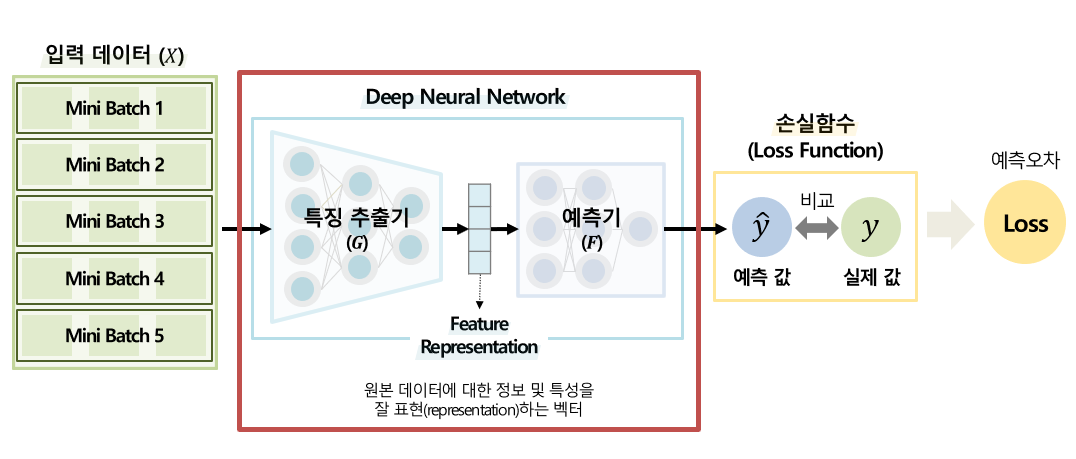

In [ ]:
Image('./images/model.PNG')

In [ ]:
class MyCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.feature_extractor_G = nn.Sequential(
                        nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(3,3),stride=(1,1),padding=(1,2)), 
                        nn.BatchNorm2d(num_features=16),
                        nn.ReLU(True),
                        nn.MaxPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0)),
                        
                        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
                        nn.BatchNorm2d(num_features=32),
                        nn.ReLU(True),
                        nn.MaxPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0)),
    
                        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
                        nn.BatchNorm2d(num_features=64),
                        nn.ReLU(True),
                        nn.MaxPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0)),
                    
                        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
                        nn.BatchNorm2d(num_features=128),
                        nn.ReLU(True),
                        nn.MaxPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0)),
                        
                        nn.Conv2d(in_channels=128,out_channels=128,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
                        nn.BatchNorm2d(num_features=128),
                        nn.ReLU(True),
                        nn.MaxPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0)))
        
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)  # Batch size index인 0을 제외하고 1부터 끝까지 모두 flatten

        self.predictor_F = nn.Sequential(nn.Linear(128*4*4, 128),
                                        nn.ReLU(True),
                                        nn.Linear(128, num_classes))
        
        self.init_weights()
        
    def forward(self, x):
        # x : B, 3, 128, 128
        representation = self.feature_extractor_G(x)   # B, 128, 4, 4
        representation_flatten = self.flatten(representation)  # B, 2048
        pred = self.predictor_F(representation_flatten) # pred -> B, num_classes
        return pred
    
    # 모델의 파라미터를 초기화
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

In [ ]:
model = MyCNN(num_classes=2)
summary(model, input_size=(3,128,128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 130]             448
       BatchNorm2d-2         [-1, 16, 128, 130]              32
              ReLU-3         [-1, 16, 128, 130]               0
         MaxPool2d-4           [-1, 16, 64, 65]               0
            Conv2d-5           [-1, 32, 64, 65]           4,640
       BatchNorm2d-6           [-1, 32, 64, 65]              64
              ReLU-7           [-1, 32, 64, 65]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,496
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
        MaxPool2d-12           [-1, 64, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]          73,856
      BatchNorm2d-14          [-1, 128,

## 3. 손실함수 정의
- **Penalty** for failing to achieve a desired value
- 모델이 성취하고자 하는 목적 및 Task에 따라서 다름: [loss function 종류](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [ ]:
"""For Classification (분류)"""
nll_loss = nn.NLLLoss()       # Negative log-likelihood loss, 모델의 마지막 레이어에서 nn.LogSoftmax를 적용한 값을 입력으로 활용
ce_fn = nn.CrossEntropyLoss() # Cross Entropy loss, 로그 확률을 직접 계산할 필요 없이, 마지막 레이어의 원 출력 값(logits)을 입력으로 받음
                              # cf. CE loss는 nn.LogSoftmax와 nn.NLLLoss의 조합으로 작동 (별도의 로그-소프트맥스 레이어 필요X)
bce_fn = nn.BCELoss()         # Binary cross-entropy loss, 이진 분류에 사용됨. 마지막 레이어에서 nn.Sigmoid 함수를 사용하여 출력을 0과 1 사이의 값으로 조정


# 출력 노드를 2개로 했기 때문에 BCE loss를 쓰려면 shape을 따로 맞춰줘야 함
criterion = nn.CrossEntropyLoss()

## 4. 순전파 (Forward)
- 입력 데이터 → 신경망 모델의 입력 layer부터 순차적으로 거쳐 최종 layer에서 출력 값을 도출
- 해당 출력 값과 실제 값(labels) 간의 차이를 손실함수를 통해 계산하여 loss 도출

### 4-1. To Device
- 모델 작동을 GPU에서 할 것인지, CPU에서 할 것인지

In [ ]:
if torch.cuda.is_available():  # gpu가 있다면
    device = 'cuda'  # cuda에 올리고
else:
    device = 'cpu'   # 그렇지 않을 시 cpu에서 작동

# 참고. if else 조건문을 한 줄로 간단히 쓰기!
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('device:', device)  # device 확인

# 모델 파라미터를 device로 이동
model.to(device)

# loss function을 device로 이동
criterion.to(device);

device: cuda


### 4-2. Model forward

In [ ]:
model.train()   # batchnorm, dropout 등 train할 때와 test할 때 연산이 다른 경우가 존재

num_iterations = len(trainloader)
train_history = {'loss': torch.zeros(num_iterations),      # 모델의 손실을 기록하기 위한 변수
                 'accuracy': torch.zeros(num_iterations)}  # 모델의 성능(accuracy)을 기록하기 위한 변수

for i, batch in enumerate(trainloader): # enumerate: for문 index와 변수를 튜플 형태로 가져와주는 class

    # X, y 데이터 명시, 두 텐서를 모델, 목적함수와 같은 device로
    input_imgs, labels = batch['X'].to(device), batch['y'].to(device)

    # forward
    logits = model(input_imgs)  # model에 input_imgs를 입력으로 넣으면 자동으로 forward 함수가 호출되어 prediction을 output으로 도출

    # Loss 계산!
    loss = criterion(logits, labels)

    # 모델 성능 계산!
    max_pred = torch.max(logits.detach(), dim=-1)[1] # 샘플 별 logit의 max 값들을 뽑기 -> [1]로 max 값들의 idx를 반환
                                                    # logit의 max 값은 모델이 해당 class로 예측했다는 의미
    accuracy = torch.eq(max_pred, labels).sum().cpu().item() / len(labels)  # 예측한 class와 정답이 얼마나 맞는지(eq) 비교하고, 맞은 개수를 합한 후 (sum) 평균 내기

    train_history['loss'][i] = loss.item()   # 'item()'은 tensor의 item 값 (상수 값)만 반환. tensor를 직접적으로 리스트에 append하면 불필요하게 메모리가 쌓이는 것 주의.
    train_history['accuracy'][i] = accuracy

train_result = {k: v.mean().item() for k, v in train_history.items()}  # train의 loss, acc를 평균내어 결과 보기

print(f"1회 forward를 수행하고 도출된 minibatch의 평균 loss 값: {train_result['loss']:.2f}")
print(f"1회 forward를 수행하고 도출된 minibatch의 평균 accuracy: {train_result['accuracy']:.2f}")

1회 forward를 수행하고 도출된 minibatch의 평균 loss 값: 1.19
1회 forward를 수행하고 도출된 minibatch의 평균 accuracy: 0.45


## 5. 역전파 (Backpropagation)
- 손실함수 값에 대한 기울기 (loss의 변화율)를 계산하여 모델의 파라미터를 어떻게 조정해야 손실을 줄일 수 있는지를 나타냄
- 계산된 기울기를 이용해서 출력 layer에서부터 입력 layer까지 거꾸로 거슬러 가며 각 layer의 파라미터에 대한 gradient를 chain rule을 통해 계산 (각 파라미터가 최종 loss에 미치는 영향을 구함)

In [ ]:
model.train()   # batchnorm, dropout 등 train할 때와 test할 때 연산이 다른 경우가 존재

num_iterations = len(trainloader)
train_history = {'loss': torch.zeros(num_iterations),      # 모델의 손실을 기록하기 위한 변수
                 'accuracy': torch.zeros(num_iterations)}  # 모델의 성능(accuracy)을 기록하기 위한 변수

for i, batch in enumerate(trainloader): # enumerate: for문 index와 변수를 튜플 형태로 가져와주는 class

    # X, y 데이터 명시, 두 텐서를 모델, 목적함수와 같은 device로
    input_imgs, labels = batch['X'].to(device), batch['y'].to(device)

    # forward
    logits = model(input_imgs)  # model에 input_imgs를 입력으로 넣으면 자동으로 forward 함수가 호출되어 prediction을 output으로 도출

    # Loss 계산!
    loss = criterion(logits, labels)

    """계산된 loss에서 gradient를 계산하는 역전파 함수: .backward()"""
    loss.backward()  # PyTorch 자동 미분

    # 모델 성능 계산!
    max_pred = torch.max(logits.detach(), dim=-1)[1] # 샘플 별 logit의 max 값들을 뽑기 -> [1]로 max 값들의 idx를 반환
                                                    # logit의 max 값은 모델이 해당 class로 예측했다는 의미
    accuracy = torch.eq(max_pred, labels).sum().cpu().item() / len(labels)  # 예측한 class와 정답이 얼마나 맞는지(eq) 비교하고, 맞은 개수를 합한 후 (sum) 평균 내기

    train_history['loss'][i] = loss.item()   # 'item()'은 tensor의 item 값 (상수 값)만 반환. tensor를 직접적으로 리스트에 append하면 불필요하게 메모리가 쌓이는 것 주의.
    train_history['accuracy'][i] = accuracy

train_result = {k: v.mean().item() for k, v in train_history.items()}  # train의 loss, acc를 평균내어 결과 보기

print(f"1회 forward를 수행하고 도출된 minibatch의 평균 loss 값: {train_result['loss']:.2f}")
print(f"1회 forward를 수행하고 도출된 minibatch의 평균 accuracy: {train_result['accuracy']:.2f}")

1회 forward를 수행하고 도출된 minibatch의 평균 loss 값: 1.21
1회 forward를 수행하고 도출된 minibatch의 평균 accuracy: 0.45


## 6. 모델의 파라미터 업데이트
- `Optimizer`를 이용하여 모델 파라미터를 업데이트! (목표: 손실 함수의 값을 최소화-혹은 최적화 문제에 따라 최대화- 하는 방향으로 파라미터 최적화)

### 6-1. Optimizer
- 최적의 파라미터를 찾기 위해 파라미터 업데이트를 담당하는 중요 요소 (성능과 직결)
- `Gradient`를 활용하여 파라미터 업데이트 **이동 방향** 및 **얼마나 이동할 지**를 설정
    - Gradient Descent: gradient의 역방향으로 & gradient의 크기만큼 이동
- `학습률(learning rate)`이라는 하이퍼파라미터를 이용하여 **이동 정도**를 조절
    - gradient의 크기만으로 결정할 시 이동이 불안정할 수 있기에, learning rate로 조절
    - learning rate이 너무 크면 수렴을 못할 수 있고, 너무 작으면 학습이 느리게 진행됨 (적절한 값 설정 중요)
    - 일반적으로 0.01 ~ 0.0001 사이를 많이 이용
    - 학습 초반에는 크게, 후반에는 작게 설정하는 scheduler 방식을 활용하기도 함  

- Optimizer 알고리즘에는 여러 종류가 있음: [optimizer 종류](https://pytorch.org/docs/stable/optim.html)

In [ ]:
# loss.backward를 통해서 gradient를 계산하고 실제로 파라미터를 업데이트 하는 역할

sgd = torch.optim.SGD(params=model.parameters(), # 최적화 할 모델 파라미터
                      lr=0.01, # 학습률
                      momentum=0.9 # 과거 그레디언트 가중합 파라미터
                      # weight_decay=5e-4, l2 정규화 강도 파라미터
                      )

adam = torch.optim.Adam(params=model.parameters(), # 최적화 할 모델 파라미터
                      lr=0.01 # 학습률
                      # betas=(0.9,0.999) # (momentum, adaptive lr momentum)
                      # weight_decay=5e-4, l2 정규화 강도 파라미터
                      )
del sgd, adam

optimizer = torch.optim.SGD(params=model.parameters(),  # 어떤 모델의 파라미터를 업데이트 할 것인지를 입력
                      lr=0.001,
                      momentum=0.9,     # SGD가 local minima에 빠져 벗어나지 못하는 단점 보완 위함
                      weight_decay=5e-4 # parameter값이 너무 커지지 않도록 규제 
                      )

In [ ]:
model.train()   # batchnorm, dropout 등 train할 때와 test할 때 연산이 다른 경우가 존재

num_iterations = len(trainloader)
train_history = {'loss': torch.zeros(num_iterations),      # 모델의 손실을 기록하기 위한 변수
                 'accuracy': torch.zeros(num_iterations)}  # 모델의 성능(accuracy)을 기록하기 위한 변수

for i, batch in enumerate(trainloader): # enumerate: for문 index와 변수를 튜플 형태로 가져와주는 class

    # X, y 데이터 명시, 두 텐서를 모델, 목적함수와 같은 device로
    input_imgs, labels = batch['X'].to(device), batch['y'].to(device)

    # forward
    logits = model(input_imgs)  # model에 input_imgs를 입력으로 넣으면 자동으로 forward 함수가 호출되어 prediction을 output으로 도출

    # Loss 계산!
    loss = criterion(logits, labels)

    """계산된 loss에서 gradient를 계산하는 역전파 함수: .backward()"""
    loss.backward()  # PyTorch 자동 미분

    """optimizer를 이용한 파라미터 업데이트"""
    optimizer.step()
    
    """Optimizer Gradient 초기화"""
    optimizer.zero_grad()

    # 모델 성능 계산!
    max_pred = torch.max(logits.detach(), dim=-1)[1] # 샘플 별 logit의 max 값들을 뽑기 -> [1]로 max 값들의 idx를 반환
                                                    # logit의 max 값은 모델이 해당 class로 예측했다는 의미
    accuracy = torch.eq(max_pred, labels).sum().cpu().item() / len(labels)  # 예측한 class와 정답이 얼마나 맞는지(eq) 비교하고, 맞은 개수를 합한 후 (sum) 평균 내기

    train_history['loss'][i] = loss.item()   # 'item()'은 tensor의 item 값 (상수 값)만 반환. tensor를 직접적으로 리스트에 append하면 불필요하게 메모리가 쌓이는 것 주의.
    train_history['accuracy'][i] = accuracy

train_result = {k: v.mean().item() for k, v in train_history.items()}  # train의 loss, acc를 평균내어 결과 보기

print(f"1회 forward와 backward를 수행하고 도출된 minibatch의 평균 loss 값: {train_result['loss']:.2f}")
print(f"1회 forward와 backward를 수행하고 도출된 minibatch의 평균 accuracy: {train_result['accuracy']:.2f}")

1회 forward와 backward를 수행하고 도출된 minibatch의 평균 loss 값: 1.30
1회 forward와 backward를 수행하고 도출된 minibatch의 평균 accuracy: 0.52


### 6-2. Model Train
- 학습 횟수 Epochs 만큼 model forward와 backward를 반복
- 반복 학습

In [ ]:
model.train()   # batchnorm, dropout 등 train할 때와 test할 때 연산이 다른 경우가 존재

epochs = 10
epoch_history = {'train_loss': [],
                 'train_acc': []}

for epoch in range(1, epochs+1):
    num_iterations = len(trainloader)
    train_history = {'loss': torch.zeros(num_iterations),      # 모델의 손실을 기록하기 위한 변수
                    'accuracy': torch.zeros(num_iterations)}  # 모델의 성능(accuracy)을 기록하기 위한 변수

    for i, batch in enumerate(trainloader): # enumerate: for문 index와 변수를 튜플 형태로 가져와주는 class

        # X, y 데이터 명시, 두 텐서를 모델, 목적함수와 같은 device로
        input_imgs, labels = batch['X'].to(device), batch['y'].to(device)

        # forward
        logits = model(input_imgs)  # model에 input_imgs를 입력으로 넣으면 자동으로 forward 함수가 호출되어 prediction을 output으로 도출

        # Loss 계산!
        loss = criterion(logits, labels)

        """계산된 loss에서 gradient를 계산하는 역전파 함수: .backward()"""
        loss.backward()  # PyTorch 자동 미분

        """optimizer를 이용한 파라미터 업데이트"""
        optimizer.step()
        
        """Optimizer Gradient 초기화"""
        optimizer.zero_grad()

        # 모델 성능 계산!
        max_pred = torch.max(logits.detach(), dim=-1)[1] # 샘플 별 logit의 max 값들을 뽑기 -> [1]로 max 값들의 idx를 반환
                                                        # logit의 max 값은 모델이 해당 class로 예측했다는 의미
        accuracy = torch.eq(max_pred, labels).sum().cpu().item() / len(labels)  # 예측한 class와 정답이 얼마나 맞는지(eq) 비교하고, 맞은 개수를 합한 후 (sum) 평균 내기

        train_history['loss'][i] = loss.item()   # 'item()'은 tensor의 item 값 (상수 값)만 반환. tensor를 직접적으로 리스트에 append하면 불필요하게 메모리가 쌓이는 것 주의.
        train_history['accuracy'][i] = accuracy

    train_result = {k: v.mean().item() for k, v in train_history.items()}  # train의 loss, acc를 평균내어 결과 보기

    print(f"{epoch}회 학습을 수행하고 도출된 minibatch의 평균 loss 값: {train_result['loss']:.2f}")
    print(f"{epoch}회 학습을 수행하고 도출된 minibatch의 평균 accuracy: {train_result['accuracy']:.2f}")

    epoch_history['train_loss'].append(train_result['loss'])
    epoch_history['train_acc'].append(train_result['accuracy'])

1회 학습을 수행하고 도출된 minibatch의 평균 loss 값: 1.60
1회 학습을 수행하고 도출된 minibatch의 평균 accuracy: 0.52
2회 학습을 수행하고 도출된 minibatch의 평균 loss 값: 0.81
2회 학습을 수행하고 도출된 minibatch의 평균 accuracy: 0.64
3회 학습을 수행하고 도출된 minibatch의 평균 loss 값: 1.02
3회 학습을 수행하고 도출된 minibatch의 평균 accuracy: 0.54
4회 학습을 수행하고 도출된 minibatch의 평균 loss 값: 0.69
4회 학습을 수행하고 도출된 minibatch의 평균 accuracy: 0.61
5회 학습을 수행하고 도출된 minibatch의 평균 loss 값: 0.87
5회 학습을 수행하고 도출된 minibatch의 평균 accuracy: 0.56
6회 학습을 수행하고 도출된 minibatch의 평균 loss 값: 0.73
6회 학습을 수행하고 도출된 minibatch의 평균 accuracy: 0.63
7회 학습을 수행하고 도출된 minibatch의 평균 loss 값: 0.63
7회 학습을 수행하고 도출된 minibatch의 평균 accuracy: 0.63
8회 학습을 수행하고 도출된 minibatch의 평균 loss 값: 0.72
8회 학습을 수행하고 도출된 minibatch의 평균 accuracy: 0.55
9회 학습을 수행하고 도출된 minibatch의 평균 loss 값: 0.66
9회 학습을 수행하고 도출된 minibatch의 평균 accuracy: 0.64
10회 학습을 수행하고 도출된 minibatch의 평균 loss 값: 0.63
10회 학습을 수행하고 도출된 minibatch의 평균 accuracy: 0.63


### 6-3. 모델 학습 추세 시각화

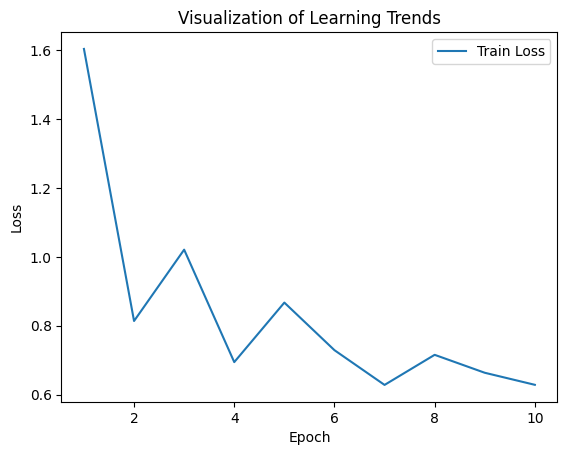

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=range(1, epochs+1), y=epoch_history['train_loss'], label="Train Loss")
plt.title("Visualization of Learning Trends")
plt.xlabel('Epoch')
plt.ylabel('Loss');

## 7. Model Valid
- 매 epoch마다 validset으로 성능을 평가하여 모델의 일반화 성능이 어느 정도인지 확인!

### 7-1. Validset을 통한 모델 일반화 성능 평가

In [ ]:
model.eval() # batchnorm, dropout 등 train할 때와 test할 때 연산이 다른 경우가 존재

num_iterations = len(validloader)
valid_history = {'loss': torch.zeros(num_iterations),      # 모델의 손실(loss)을 기록하기 위함
                'accuracy': torch.zeros(num_iterations)}   # 모델의 성능(accuracy)을 기록하기 위함

with torch.no_grad():  # 자동미분 연산 중지
    for i, batch in enumerate(validloader):
        input_imgs, labels = batch['X'].to(device), batch['y'].to(device)

        logits = model(input_imgs)

        loss = criterion(logits, labels)

        """loss를 backward 하지 않는 것에 주의"""

        # 모델 손실 및 성능 기록
        max_pred = torch.max(logits.detach(), dim=-1)[1]
        accuracy = torch.eq(max_pred, labels).sum().cpu().item() / len(labels)  # 예측한 class와 정답이 얼마나 맞는지(eq) 비교하고, 맞은 개수를 합한 후 (sum) 평균 내기

        valid_history['loss'][i] = loss.item()   # 모델 손실 저장
        valid_history['accuracy'][i] = accuracy  # 모델 성능 저장

valid_result = {k: v.mean().item() for k, v in valid_history.items()} 

print(f"Valid Loss: {valid_result['loss']:.2f}, Valid Accuracy: {valid_result['accuracy']:.2f}")

Valid Loss: 0.62, Valid Accuracy: 0.66


### 7-2. 학습 중 Validset으로 평가하였을 때, 모델의 (일반화) 성능이 가장 좋았을 때의 파라미터를 저장하는 것이 원칙

#### Recall: Save Parameters of Model

In [ ]:
save_dir = './results/CatDog'
if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)

# dictionary로 모델의 parameter뿐만 아니라 다른 정보들(ex. best epoch, best accuracy 등)을 저장
save_dict = {'model_G':model.feature_extractor_G.state_dict(),
             'model_F':model.predictor_F.state_dict(),
             'model':model.state_dict(),

             'optimizer': optimizer.state_dict()
             }
torch.save(save_dict, os.path.join(save_dir, 'model_checkpoint.pt'))

In [ ]:
import time

In [ ]:
model.train()   # batchnorm, dropout 등 train할 때와 test할 때 연산이 다른 경우가 존재

epochs = 10
best_acc = 0.0                      # 최종적으로 저장할 모델을 판단할 기준 설정 (초기화)
best_epoch = 0.0                    # 최종 모델이 몇 번째 epoch에서 도출되는지 저장 위함 (초기화)
save_dir = './results/CatDog'       # 최종 모델 결과를 저장할 경로 설정
if not os.path.exists(save_dir):    # 새롭게 만들어야 하는 경우 -> 만들기
    os.makedirs(save_dir, exist_ok=True)
epoch_history = {'train_loss': [], 'train_acc': [],
                 'valid_loss': [], 'valid_acc': []}

start = time.time()
for epoch in range(1, epochs+1):

    """Step 1: Model Training"""
    num_iterations = len(trainloader)
    train_history = {'loss': torch.zeros(num_iterations),      # 모델의 손실을 기록하기 위한 변수
                    'accuracy': torch.zeros(num_iterations)}   # 모델의 성능(accuracy)을 기록하기 위한 변수

    for i, batch in enumerate(trainloader): # enumerate: for문 index와 변수를 튜플 형태로 가져와주는 class

        # X, y 데이터 명시, 두 텐서를 모델, 목적함수와 같은 device로
        input_imgs, labels = batch['X'].to(device), batch['y'].to(device)

        # forward
        logits = model(input_imgs)  # model에 input_imgs를 입력으로 넣으면 자동으로 forward 함수가 호출되어 prediction을 output으로 도출

        # Loss 계산!
        loss = criterion(logits, labels)

        """계산된 loss에서 gradient를 계산하는 역전파 함수: .backward()"""
        loss.backward()  # PyTorch 자동 미분

        """optimizer를 이용한 파라미터 업데이트"""
        optimizer.step()
        
        """Optimizer Gradient 초기화"""
        optimizer.zero_grad()

        # 모델 성능 계산!
        max_pred = torch.max(logits.detach(), dim=-1)[1] # 샘플 별 logit의 max 값들을 뽑기 -> [1]로 max 값들의 idx를 반환
                                                        # logit의 max 값은 모델이 해당 class로 예측했다는 의미
        accuracy = torch.eq(max_pred, labels).sum().cpu().item() / len(labels)  # 예측한 class와 정답이 얼마나 맞는지(eq) 비교하고, 맞은 개수를 합한 후 (sum) 평균 내기

        train_history['loss'][i] = loss.item()   # 'item()'은 tensor의 item 값 (상수 값)만 반환. tensor를 직접적으로 리스트에 append하면 불필요하게 메모리가 쌓이는 것 주의.
        train_history['accuracy'][i] = accuracy

    train_result = {k: v.mean().item() for k, v in train_history.items()}  # train의 loss, acc를 평균내어 결과 보기
    print(f"Epoch: {epoch}, Train Loss: {train_result['loss']:.2f}, Train Accuracy: {train_result['accuracy']:.2f}")

    """Step 2: Model Validation (Evaluation)"""
    model.eval() # batchnorm, dropout 등 train할 때와 test할 때 연산이 다른 경우가 존재

    num_iterations = len(validloader)
    valid_history = {'loss': torch.zeros(num_iterations),      # 모델의 손실(loss)을 기록하기 위함
                    'accuracy': torch.zeros(num_iterations)}   # 모델의 성능(accuracy)을 기록하기 위함

    with torch.no_grad():  # 자동미분 연산 중지
        for i, batch in enumerate(validloader):
            input_imgs, labels = batch['X'].to(device), batch['y'].to(device)

            logits = model(input_imgs)

            loss = criterion(logits, labels)

            """loss를 backward 하지 않는 것에 주의"""

            # 모델 손실 및 성능 기록
            max_pred = torch.max(logits.detach(), dim=-1)[1]
            accuracy = torch.eq(max_pred, labels).sum().cpu().item() / len(labels)  # 예측한 class와 정답이 얼마나 맞는지(eq) 비교하고, 맞은 개수를 합한 후 (sum) 평균 내기

            valid_history['loss'][i] = loss.item()   # 모델 손실 저장
            valid_history['accuracy'][i] = accuracy  # 모델 성능 저장

    valid_result = {k: v.mean().item() for k, v in valid_history.items()} 
    print(f"Epoch: {epoch}, Valid Loss: {valid_result['loss']:.2f}, Valid Accuracy: {valid_result['accuracy']:.2f}", "\n")

    """Step 3: 학습 중 도출된 loss 및 acc 값들 저장"""
    epoch_history['train_loss'].append(train_result['loss'])
    epoch_history['train_acc'].append(train_result['accuracy'])
    epoch_history['valid_loss'].append(valid_result['loss'])
    epoch_history['valid_acc'].append(valid_result['accuracy'])

    """Step 4: 모델을 평가 (valid/eval) 하였을 때 성능 측면에서 가장 우수했던 모델을 저장"""
    if valid_result['accuracy'] > best_acc:
        best_acc = valid_result['accuracy']  # best acc 값 업데이트
        best_epoch = epoch                   # best epoch 값 업데이트
        save_dict = {'model_G':model.feature_extractor_G.state_dict(),
                    'model_F':model.predictor_F.state_dict(),
                    'model':model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'epoch':best_epoch,
                    'acc':best_acc}
        torch.save(save_dict, os.path.join(save_dir, 'model_checkpoint.pt'))  # 모델 저장

# 최종적으로 선택된 모델에 대한 값 확인
print(f"Best Accuracy:{best_acc:.2f} | Best Epoch:{best_epoch}")

# 학습/테스트에 소요된 시간 계산
end_sec = time.time() - start

Epoch: 1, Train Loss: 0.62, Train Accuracy: 0.68
Epoch: 1, Valid Loss: 0.63, Valid Accuracy: 0.66 

Epoch: 2, Train Loss: 0.65, Train Accuracy: 0.65
Epoch: 2, Valid Loss: 0.67, Valid Accuracy: 0.58 

Epoch: 3, Train Loss: 0.58, Train Accuracy: 0.72
Epoch: 3, Valid Loss: 0.65, Valid Accuracy: 0.60 

Epoch: 4, Train Loss: 0.62, Train Accuracy: 0.69
Epoch: 4, Valid Loss: 0.65, Valid Accuracy: 0.60 

Epoch: 5, Train Loss: 0.61, Train Accuracy: 0.69
Epoch: 5, Valid Loss: 0.66, Valid Accuracy: 0.60 

Epoch: 6, Train Loss: 0.54, Train Accuracy: 0.76
Epoch: 6, Valid Loss: 0.69, Valid Accuracy: 0.58 

Epoch: 7, Train Loss: 0.59, Train Accuracy: 0.72
Epoch: 7, Valid Loss: 0.73, Valid Accuracy: 0.50 

Epoch: 8, Train Loss: 0.52, Train Accuracy: 0.77
Epoch: 8, Valid Loss: 0.66, Valid Accuracy: 0.60 

Epoch: 9, Train Loss: 0.60, Train Accuracy: 0.74
Epoch: 9, Valid Loss: 0.62, Valid Accuracy: 0.65 

Epoch: 10, Train Loss: 0.49, Train Accuracy: 0.84
Epoch: 10, Valid Loss: 0.61, Valid Accuracy: 0.63 

### 7-3. 모델 학습 추세 시각화

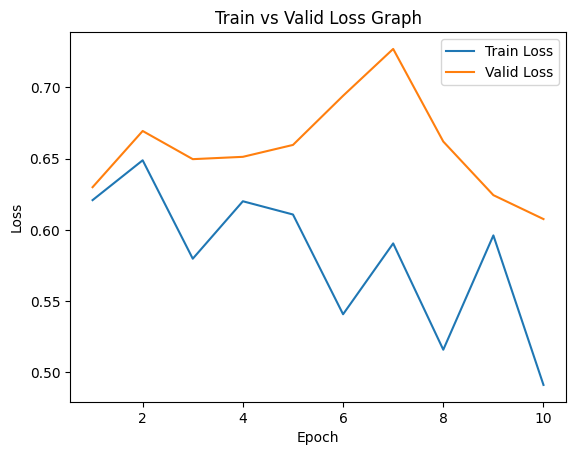

In [ ]:
sns.lineplot(x=range(1, epochs+1), y=epoch_history['train_loss'], label="Train Loss")
sns.lineplot(x=range(1, epochs+1), y=epoch_history['valid_loss'], label="Valid Loss")
plt.title("Train vs Valid Loss Graph")
plt.xlabel('Epoch')
plt.ylabel('Loss');

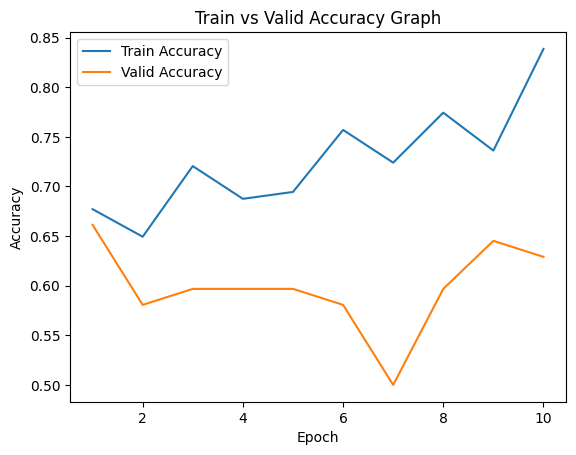

In [ ]:
sns.lineplot(x=range(1, epochs+1), y=epoch_history['train_acc'], label="Train Accuracy")
sns.lineplot(x=range(1, epochs+1), y=epoch_history['valid_acc'], label="Valid Accuracy")
plt.title("Train vs Valid Accuracy Graph")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="best");

## 8. Model Test: 최종적인 모델 성능 평가

### 8-1. Load Parameters of Model

In [ ]:
# load model parameters / 모델 구조를 불러온 뒤 parameter를 해당 레이어로 load해줘야함
test_model = MyCNN(num_classes=2).to(device)   # 모델 구조 선언

load_dict = torch.load(os.path.join(save_dir, 'model_checkpoint.pt'))   # 딕셔너리 형태로 저장된 모델의 체크포인트 불러오기
parameters = load_dict['model']    # 'model'의 파라미터를 불러오기
test_model.load_state_dict(parameters, strict=False)

test_model

MyCNN(
  (feature_extractor_G): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (

### 8-2. Model Test

In [ ]:
# test
test_acc = 0.0
n_test = 0

num_iterations = len(testloader)
test_history = {'accuracy': torch.zeros(num_iterations)}

test_model.eval()
with torch.no_grad():
    for i, batch in enumerate(testloader):
        input_imgs, labels = batch['X'].to(device), batch['y'].to(device)
        
        logits = model(input_imgs) # B,2
        
        # max함수를 통한 예측값 생성
        max_pred = torch.max(logits, dim=1)[1] # B
        test_accuracy = torch.eq(max_pred, labels).sum().cpu().item() / len(labels)
        test_history['accuracy'][i] = test_accuracy

test_result = {k: v.mean().item() for k, v in test_history.items()} 

# 학습 정보 출력
print(f'Data      : dog_cat')
print(f'Seed      : {seed}')
print(f'Model     : MyCNN')
print(f'valid ACC : {load_dict["acc"]:.2f}')
print(f'test ACC  : {test_result['accuracy']:.2f} \n')

Data      : dog_cat
Seed      : 0
Model     : MyCNN
valid ACC : 0.66
test ACC  : 0.61 

